In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import scipy.stats as sps
import random
import copy

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import f1_score

from tqdm import tqdm

In [242]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [84]:
links = pd.read_csv('/content/links.csv')
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')
#tags = pd.read_csv('/content/tags.csv')

In [85]:
ratings = ratings.iloc[0:len(ratings)//10]

data = pd.merge(ratings, movies, on='movieId', how='left')
data = data[['userId', 'movieId', 'rating', 'genres', 'timestamp']]
data['genres'] = data['genres'].str.split('|')


mlb = MultiLabelBinarizer()
genre_features = pd.DataFrame(mlb.fit_transform(data['genres']), columns=mlb.classes_)

data = pd.concat([data, genre_features], axis=1)
genre_columns = set(data.columns) - set(['userId', 'movieId',
                                         'genres', 'rating', 'timestamp'])
data.head(4)

,userId,movieId,rating,genres,timestamp,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",964982703,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,"[Comedy, Romance]",964981247,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,"[Action, Crime, Thriller]",964982224,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,"[Mystery, Thriller]",964983815,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [86]:
data['userId'] = data['userId'].astype('category').cat.codes
data['movieId'] = data['movieId'].astype('category').cat.codes

# Нормализуем рейтинги
scaler = MinMaxScaler(feature_range=(0, 1))

data['rating'] = scaler.fit_transform(data[['rating']])
data['rating_label'] = (data['rating'] >= 0.7).astype('int')

In [87]:
data['rating_label'].describe()

,rating_label
count,10083.000000
mean,0.500545
std,0.500024
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


### Делаем эмбеддинги

In [88]:
class RecDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['userId'].values, dtype=torch.long)
        self.movies = torch.tensor(data['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(data['rating_label'].values, dtype=torch.float32)
        self.genres = torch.tensor(data[list(genre_columns)].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.genres[idx], self.ratings[idx]


In [89]:
class TrainEmbModel(nn.Module):
    def __init__(self,
                 num_users,
                 num_items,
                 num_genres,
                 embedding_user_dim,
                 embedding_item_dim,
                 extra_param_embedding_dim,
                 hidden_size=25):

        super(TrainEmbModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_user_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_item_dim)
        self.genre_fc = nn.Linear(num_genres, extra_param_embedding_dim)

        self.fc1 = nn.Linear(embedding_item_dim + embedding_user_dim +
                             extra_param_embedding_dim, hidden_size)

        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1) #т.к. решаем задачу бинарной классификации
        self.sigmoid = nn.Sigmoid()


    def forward(self, user_ids, item_ids, genre_vectors):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        genre_emb = self.genre_fc(genre_vectors)

        nn_input = torch.cat([user_emb, item_emb, genre_emb], dim=1)

        fc1_output = self.fc1(nn_input)
        fc2_output = self.fc2(self.relu(fc1_output))
        return self.sigmoid(fc2_output)


In [90]:
train, test = train_test_split(data, test_size=0.2)
train_dataset = RecDataset(train)
test_dataset = RecDataset(test)
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)

In [91]:
params = {'num_users' : len(data['userId'].unique()),
'num_items' : len(data['movieId'].unique()),
'num_genres' : len(genre_columns),
'embedding_user_dim' : 10,
'embedding_item_dim' : 10,
'extra_param_embedding_dim' : 10}


model = TrainEmbModel(**params).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005)
criterion = nn.BCELoss()

In [92]:
for epoch in range(1):
    model.train()
    for user_ids, movie_ids, genres, ratings in train_loader:
        user_ids = user_ids.to(device)
        movie_ids = movie_ids.to(device)
        genres = genres.to(device)
        ratings = ratings.to(device)
        optimizer.zero_grad()
        predictions = model(user_ids, movie_ids, genres)
        loss = criterion(predictions.squeeze(), ratings)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.6926762461662292


In [93]:
train_dataset[0]

(tensor(9),
 tensor(1595),
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor(1.))

In [94]:
users_embedding_0 = model.user_embedding(torch.tensor(list(np.sort(data['userId'].unique())),
                                                      dtype=torch.long).to(device))
users_embedding_0.shape

torch.Size([66, 10])

In [95]:
movies['genres']

,genres
0,Adventure|Animation|Children|Comedy|Fantasy
1,Adventure|Children|Fantasy
2,Comedy|Romance
3,Comedy|Drama|Romance
4,Comedy
...,...
9737,Action|Animation|Comedy|Fantasy
9738,Animation|Comedy|Fantasy
9739,Drama
9740,Action|Animation


In [96]:
movies['genres'] = movies['genres'].str.split('|')
genre_to_movies = pd.DataFrame(mlb.transform(movies['genres']), columns=mlb.classes_)

genre_to_movies

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Смотрим на распределение Эмбеддингов

In [97]:
df = data.copy(deep=True)
df = df.sort_values(by=['userId'])

# Создаем столбец 'wasnot_later'
df['wasnot_later'] = (df.groupby(['movieId']).cumcount() == 0).astype(int)

df = df[df['wasnot_later'] == 1]
movie_emb = model.item_embedding( torch.tensor(list(df['movieId'].values), dtype=torch.long ).to(device) )

genre_emb = model.genre_fc(torch.tensor(df[list(genre_columns)].values, dtype=torch.float32).to(device) )

item_embedding_0 = torch.cat([movie_emb, genre_emb], dim=1)
item_embedding_0.shape


torch.Size([3221, 20])

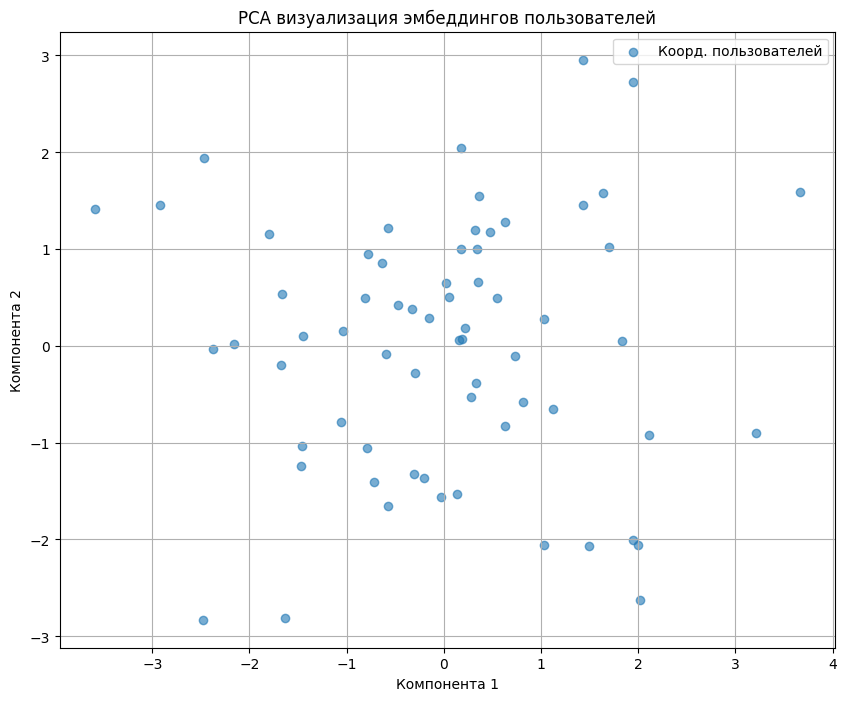

In [98]:
tsne = PCA(n_components=2)
embeddings_2d = tsne.fit_transform(users_embedding_0.detach().cpu().numpy())
mean_hat = np.mean(users_embedding_0.detach().cpu().numpy(), axis=0)
cov_hat = np.cov(users_embedding_0.detach().cpu().numpy(), rowvar=False)

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            alpha=0.6, label='Коорд. пользователей')

plt.title("PCA визуализация эмбеддингов пользователей")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.legend()
plt.grid(True)
plt.show()

In [99]:
from statsmodels.stats.multitest import multipletests
alpha = 0.05
pvalues = []
for i in range(users_embedding_0.detach().cpu().numpy().shape[1]):
    statistic, p_value = sps.kstest(users_embedding_0.detach().cpu().numpy()[:, i],
                                'norm', args=(mean_hat[i], np.sqrt(cov_hat[i, i])))
    pvalues.append(p_value)

reject, p_corrected, _, _ = multipletests(pvalues, method='fdr_bh')
print("Скорректированные p-значения (Бенджамини-Хохберг):", p_corrected)

Скорректированные p-значения (Бенджамини-Хохберг): [0.97702805 0.97702805 0.97702805 0.97702805 0.97702805 0.97702805
 0.97702805 0.97702805 0.97702805 0.97702805]


Данные с очень большой вероятностью – НОРМАЛЬНЫЕ!

In [19]:
'''
  tsne = TSNE(n_components=2, random_state=42)
  embeddings_2d = tsne.fit_transform(item_embedding_0.detach().cpu().numpy())

  # Визуализация
  plt.figure(figsize=(10, 8))
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
  plt.title("t-SNE визуализация эмбеддингов фильмов")
  plt.xlabel("Компонента 1")
  plt.ylabel("Компонента 2")
  plt.grid(True)
  plt.show()
'''

'\n  tsne = TSNE(n_components=2, random_state=42)\n  embeddings_2d = tsne.fit_transform(item_embedding_0.detach().cpu().numpy())\n\n  # Визуализация\n  plt.figure(figsize=(10, 8))\n  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)\n  plt.title("t-SNE визуализация эмбеддингов фильмов")\n  plt.xlabel("Компонента 1")\n  plt.ylabel("Компонента 2")\n  plt.grid(True)\n  plt.show()\n'

Опишем эксперимент более подробно:

У нас есть 4 алгоритма, с возможностью изменения параметров в процессе обучения.


Считаем, что далее мы работаем с пользователями $u$ и товарами $i$ как с векторами из конечномерного линейного пространства. Эти эмбеддинги мы получили с помощью обучения алгоритма классификации и вычленили веса первого слоя.

\\


В каждый момент времени у нас есть $\mathcal{D}_t$ – датасет. Формально, он представляет из себя кортеж из трёх элементов: $\mathcal{D}_t = (U_t, I_t, M_t)$, где $U_t$ -- множество пользователей, находящихся в системе в данный момент времени. Аналогично $I_t$ – это множество товаров, находящихся в системе в данный момент времени. $M_t$ – это, неформально, матрица размерности $\mathbb{R}^{|U_t| \times |I_t|}$, где $\big(M_t\big)_{ij} = \text{оценка пользователя } U_i \text{ на  товар } I_j$

\\


$a_{rec}$ – алгоритм рекомендаций.

$a_{choice}$ – алгоритм выбора пользователем товаров

$itemGAN$ – алгоритм, который в момент времени t возвращает все товары, которые будут на шаге ${t+1}$ (т.е. модифицирует массив всех товаров с шага $t$, добавляя в него как новые товары, так и удаляя старые товары)

$userGAN$ – алгоритм, который в момент времени t возвращает массив пользователей, которые будут на шаге ${t+1}$. Аналогично $itemGAN$


 \\

****
Говоряя более подробно о сути этих алгоритмов, как отображений:

1) $a_{rec} : U \times I \rightarrow [0; 1]$

2) $a_{choice} : U \times I^K \rightarrow 2^{\{1, 2, \ldots K\}}$

3) $itemGAN: (I_t, M_t) \mapsto (I_{t+1}, M_{t+1})$

4) $userGAN : (U_t, M_t) \mapsto (U_{t+1}, M_{t+1})$



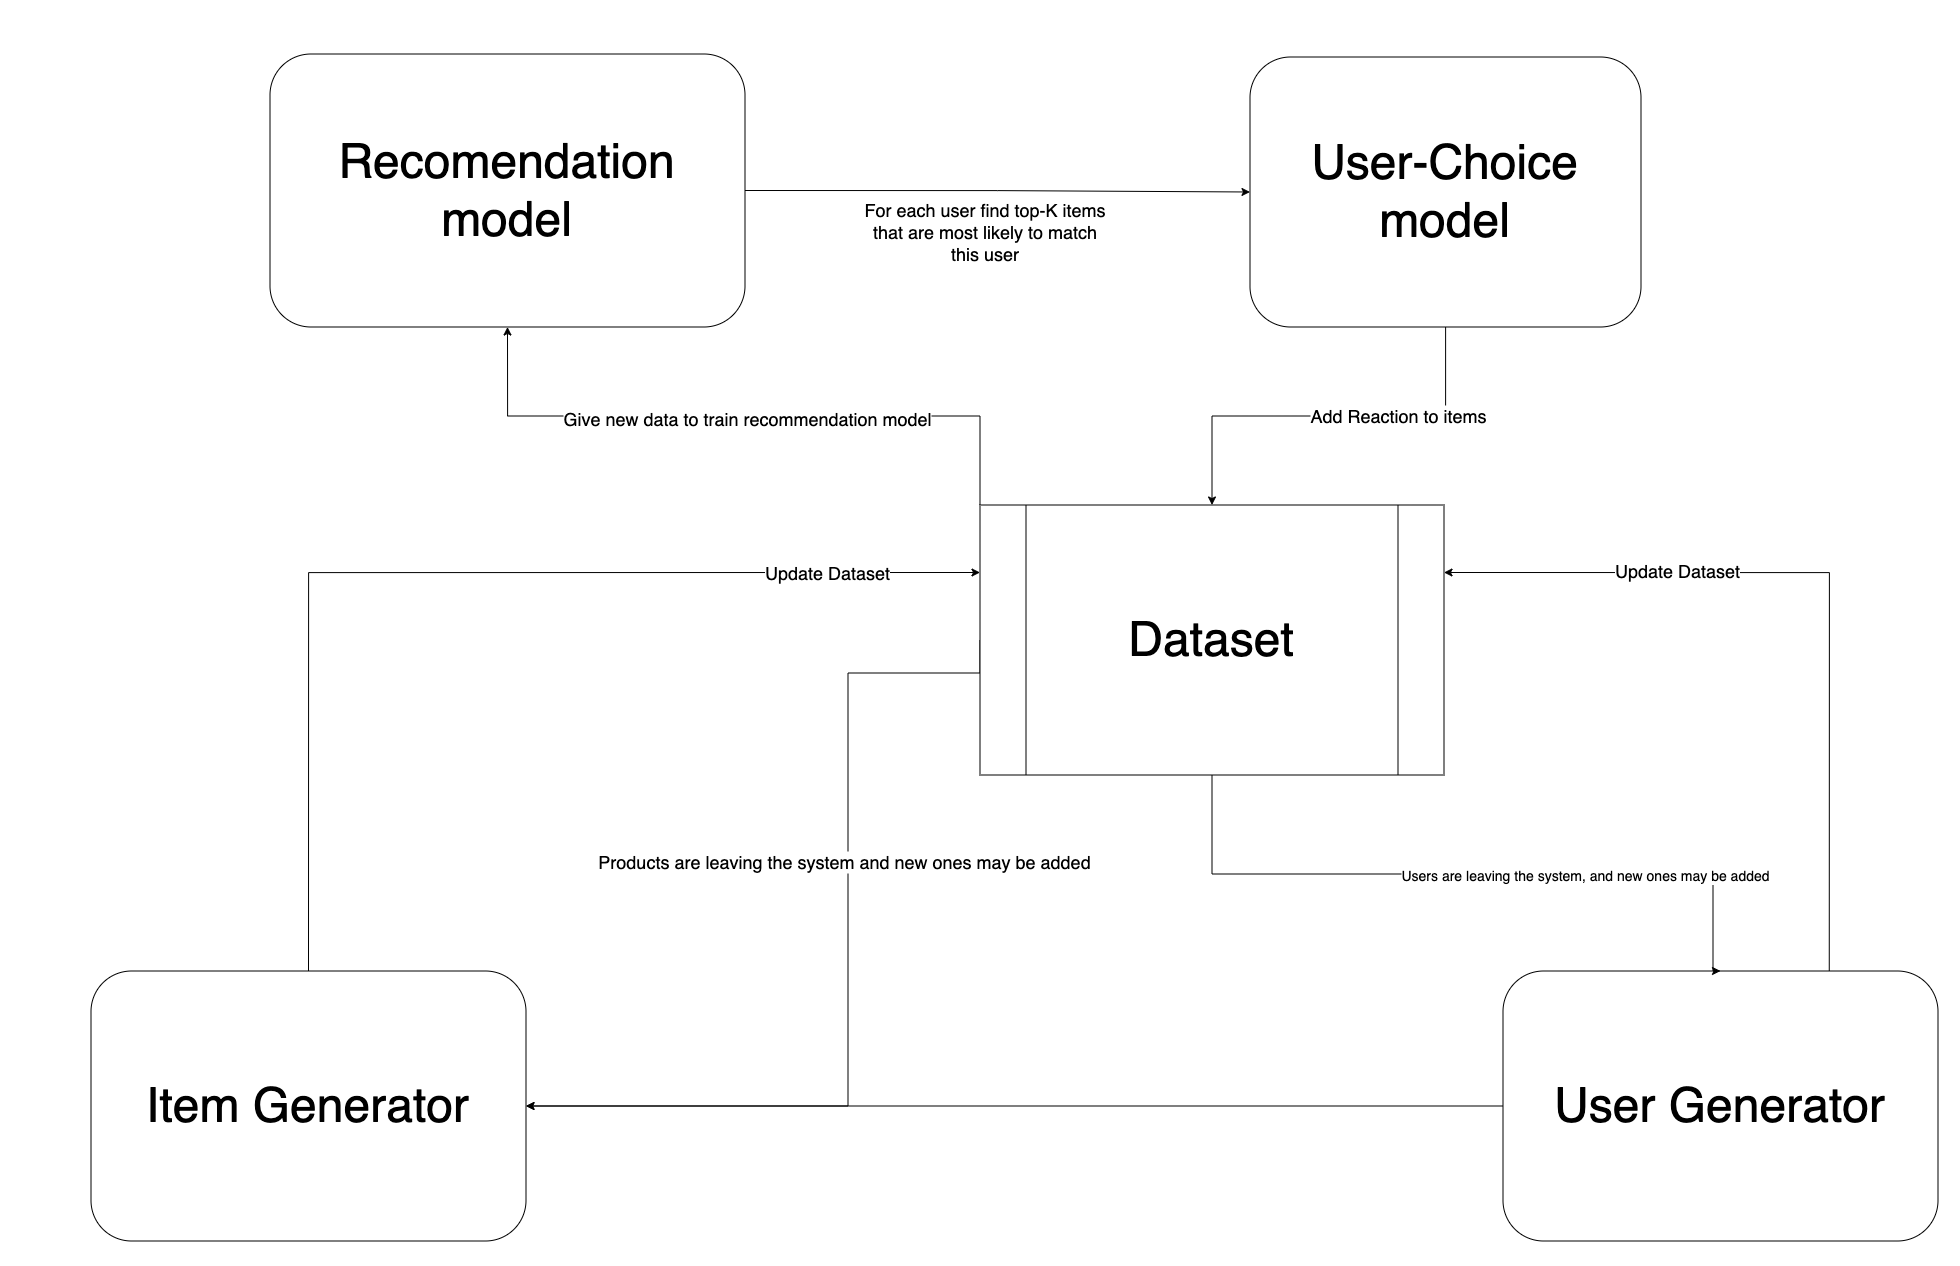

**При этом, в качестве реализаций этих алгоритмов мы будем использовать нейронные сети.**


$a_{rec}$ – нейронная сеть, обучающаяся предсказывать 0/1 – понравится ли конкретный айтем $i$ пользователю $u$. Использует $BCE-Loss$ и содержит два полносвязных слоя с функцией активацией $ReLU$

\\

$a_{choice}$ – неройнная сеть, которая обучается предсказывать по входу: $(u, (i_1, \ldots i_K))$ вектор размерности $K$, где единица на $l$-ой позиции будет означать, что пользователь выбрал айтем $i_l$. Эта модель решает задачу мультиклассовой классификации (multi-label classification). Для решения этой задачи мы тоже используем $BCE-Loss$, а также двухслойную-полносвязную нейронную сеть.

\\


Перед тем как окончательно решить, что в рамках этой задачи можно использовать как векторное представление (т.е. эмбеддинги) веса одной предварительно обученной сети, мы рассмотрели распределение этих векторов-эмбеддингов. Получилось что эти вектора из нормального распределения. Что подтверждается статистическими тестами. Тогда $itemGAN$ на шаге $t$ будет оценивать распределение параметров многомерного нормального распределения по массиву $U_t$ (т.е. массиву пользователей, находящихся в данный момент времени в системе) и уже семплировать из этого распределения нужно количество пользователей. Полностью аналогично работает и $userGAN$


### Определяем модели

#### Определяем структуры данных, которые будем использовать

Фильмы и пользователи до начала эксперимента закодированы их `id`,

 $\text{userId} \in [0; 609], \quad \text{movieId} \in [0; 9723]$

In [100]:
class ExperimentDataset():
    def __init__(self, user_embeddings, items_embeddings, rating_matrix):
        self.users_embeddings = user_embeddings
        self.items_embeddings = items_embeddings
        self.matrix = rating_matrix

    def update(self, new_users, new_items, new_ratings):
        self.user_embeddings = copy.deepcopy(new_users)
        self.items_embeddings = copy.deepcopy(new_items)
        self.matrix = copy.deepcopy(new_ratings)

    def update_ratings(self, interactions, t):
      '''
      Обновляет список взаимодействий между пользователем и фильмом

      :param interactions: список пользователей
      :type list:
      '''
      if len(interactions) >= 1:
        interactions = np.array(interactions)
        user_ids = interactions[:, 0]
        item_ids = interactions[:, 1]
        self.matrix[user_ids, item_ids] = t


In [101]:
class EfficientNaNUserBehaviorDataset(Dataset):
    def __init__(self, dataset, K, user_embedding_dim, item_embedding_dim):
        self.matrix = dataset.matrix
        self.dataset = dataset
        self.K = K

        # Предварительно вычисляем индексы не-NaN элементов для каждого пользователя
        self.user_watched = [np.where(~np.isnan(self.matrix[i]))[0]
                           for i in range(self.matrix.shape[0])]

        # Генерируем данные
        self.data = self._generate_data()

    def _generate_data(self):
        data = []
        for user_idx, watched in enumerate(self.user_watched):
            if len(watched) == 0:
                continue

            # Генерируем K случайных рекомендаций из просмотренных
            recs = np.random.choice(watched, size=min(self.K, len(watched)), replace=False)
            labels = (self.matrix[user_idx, recs] > 0.5).astype(float)
            data.append((user_idx, recs, labels))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_idx, recs, labels = self.data[idx]

        user = torch.FloatTensor(self.dataset.users_embeddings[user_idx])
        items = torch.FloatTensor(self.dataset.items_embeddings[recs])
        labels = torch.FloatTensor(labels)

        return user, items, labels

In [102]:
import scipy.sparse as sp

class OptimizedUserBehaviorDataset(Dataset):
    def __init__(self, dataset, K, user_embedding_dim, item_embedding_dim):
        # Преобразуем в CSR формат для эффективной работы с разреженными данными
        self.matrix = sp.csr_matrix(dataset.matrix)
        self.dataset = dataset
        self.K = K
        self.user_embedding_dim = user_embedding_dim
        self.item_embedding_dim = item_embedding_dim

        # Предварительно вычисляем непропущенные значения для каждого пользователя
        self.user_watched = [self.matrix.getrow(i).indices for i in range(self.matrix.shape[0])]

        # Генерируем данные один раз, без дублирования
        self.data = self._generate_optimized_data()

    def _generate_optimized_data(self):
        data = []
        for user_idx, watched in enumerate(self.user_watched):
            if len(watched) == 0:
                continue

            # Генерируем все возможные комбинации за один вызов
            all_recommendations = np.random.choice(
                watched,
                size=min(self.K * len(watched), len(watched)),
                replace=False
            )

            # Разбиваем на группы по K элементов
            for i in range(0, len(all_recommendations), self.K):
                recs = all_recommendations[i:i+self.K]
                labels = self.matrix[user_idx, recs].toarray().flatten()
                data.append((user_idx, recs, labels))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_idx, recommendations_indeces, labels = self.data[idx]

        # Используем заранее загруженные embedding'и
        user = torch.tensor(self.dataset.users_embeddings[user_idx], dtype=torch.float32)
        recommendations = torch.tensor(
            self.dataset.items_embeddings[recommendations_indeces],
            dtype=torch.float32
        )
        labels = torch.tensor(labels, dtype=torch.float32)

        return user, recommendations, labels

In [103]:
class UserBehaviorDataset(Dataset):
    def __init__(self, dataset, K, user_embedding_dim, item_embedding_dim):
        self.matrix = dataset.matrix.copy()
        self.dataset = dataset
        self.K = K
        self.users_count, self.items_count = self.matrix.shape
        self.data = self._generate_data()
        self.user_embedding_dim = user_embedding_dim
        self.item_embedding_dim = item_embedding_dim

    def _generate_data(self):
        data = []
        for user_idx in range(self.users_count):
            watched = np.where(~np.isnan(self.dataset.matrix[user_idx]))[0] #получаем номера столбцов с пропусками для user'a

            if len(watched) == 0:
                continue

            for _ in range(K * len(watched)):
                # Генерируем рекомендации (K фильмов, включая как понравившиеся, так и нет)
                size = min(len(watched), self.K)
                recommendations_indeces = np.random.choice(
                    watched,
                    size=size,
                    replace=False
                )

                labels = (self.matrix[user_idx, recommendations_indeces] > 0.1).astype(float)
                data.append((user_idx, recommendations_indeces, labels))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_idx, recommendations_indeces, labels = self.data[idx]

        user = self.dataset.users_embeddings[user_idx]
        recommendations = self.dataset.items_embeddings[recommendations_indeces]
        return torch.tensor(user, dtype=torch.float32), \
               torch.tensor(recommendations, dtype=torch.float32), \
               torch.tensor(labels, dtype=torch.float32)


In [104]:
class RecommendationDataset(Dataset):
    def __init__(self, dataset, user_embedding_dim, item_embedding_dim,
                 use_PCA=True, random_components=None):
        """
        Инициализация датасета.
        :param users_embeddings: Тензор эмбеддингов пользователей (num_users, embedding_dim).
        :param items_embeddings: Тензор эмбеддингов товаров (num_items, embedding_dim).
        :param matrix: Матрица мэтчей (num_users, num_items), где 1 — понравится, 0 — не понравится.
        :param use_PCA: логическая переменная, отвечающая за то, будем ли мы понижать размерность датасета с помощью PCA.
        :param random_components: iterable объект, который содержит индексы компонент исходного вектора, которые будут использоваться
                                  для обучения и инференса. Выглядит как (user_components, item_components)
        """
        self.users_embeddings = dataset.users_embeddings.copy()
        self.items_embeddings = dataset.items_embeddings.copy()
        self.matrix = dataset.matrix.copy()
        self.user_embedding_dim = user_embedding_dim
        self.item_embedding_dim = item_embedding_dim

        # Создаем список всех пар (пользователь, товар) и соответствующих меток
        self.pairs = []
        for user_id in range(dataset.matrix.shape[0]):
            for item_id in range(dataset.matrix.shape[1]):
                label = (dataset.matrix[user_id, item_id] > 0.1).astype(float)
                if not np.isnan(label):
                  self.pairs.append((user_id, item_id, label))

        #обрезаем датасет специально
        #size = len(self.pairs)
        #random.shuffle(self.pairs)
        #self.pairs = self.pairs[:size//3]

        #понижаем размерность
        if ((user_embedding_dim != users_embeddings.shape[1]) or
            (item_embedding_dim != items_embeddings.shape[1])):

            if use_PCA:
              user_transformer = PCA(n_components=user_embedding_dim)
              item_transformer = PCA(n_components=item_embedding_dim)

              self.users_embeddings = user_transformer.fit_transform(self.users_embeddings)
              self.items_embeddings = item_transformer.fit_transform(self.items_embeddings)
            elif random_components is not None:
              user_components, item_components = random_components
              self.users_embeddings = self.users_embeddings[:, user_components]
              self.items_embeddings = self.items_embeddings[:, item_components]

    def __len__(self):
        """Возвращает количество пар (пользователь, товар)."""
        return len(self.pairs)

    def __getitem__(self, idx):
        """
        Возвращает пару (пользователь, товар) и метку.
        :param idx: Индекс пары.
        :return: Эмбеддинг пользователя, эмбеддинг товара, метка.
        """
        user_id, item_id, label = self.pairs[idx]
        user_embedding = self.users_embeddings[user_id]
        item_embedding = self.items_embeddings[item_id]

        return torch.tensor(user_embedding, dtype=torch.float32), \
               torch.tensor(item_embedding, dtype=torch.float32), \
               torch.tensor(label, dtype=torch.float32)
    def get_with_id(self, idx):
      """
      Возвращает пару (пользователь, товар) и метку.
      :param idx: Индекс пары.
      :return: Эмбеддинг пользователя, эмбеддинг товара, метка.
      """
      user_id, item_id, label = self.pairs[idx]
      user_embedding = self.users_embeddings[user_id]
      item_embedding = self.items_embeddings[item_id]

      return torch.tensor(user_embedding, dtype=torch.float32), \
            torch.tensor(item_embedding, dtype=torch.float32), \
            torch.tensor(label, dtype=torch.float32), \
            user_id, item_id

#### Объявляем алгоритмы/модели

In [105]:
class RecModel(nn.Module): #по входу: (пользователь, товар) определяет есть ли мэтч
    def __init__(self,
                 embedding_user_dim,
                 embedding_item_dim,
                 hidden_size):

        super(RecModel, self).__init__()
        self.fc1 = nn.Linear(embedding_item_dim + embedding_user_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1) #т.к. решаем задачу бинарной классификации
        self.sigmoid = nn.Sigmoid()

    def forward(self, user, item):
        nn_input = torch.cat([user, item], dim=1)

        fc1_output = self.fc1(nn_input)
        fc2_output = self.fc2(self.relu(fc1_output))
        return self.sigmoid(fc2_output.squeeze(-1))

In [106]:
class ChoiceModel(nn.Module):
    def __init__(self,
                  embedding_user_dim,
                  embedding_item_dim,
                  K,
                  hidden_size
                  ):

          super(ChoiceModel, self).__init__()
          self.fc1 = nn.Linear(embedding_item_dim + embedding_user_dim, hidden_size)
          self.relu = nn.ReLU()
          self.fc2 = nn.Linear(hidden_size, 1) #решаем задачу multi-label классификации
          self.sigmoid = nn.Sigmoid()
          self.K = K

    def forward(self, user, items):
        user = user.unsqueeze(1).expand(-1, self.K, -1) #т.к. считаем что размерности идут в таком порядке:
                                                        # [batch_size, K, emb_size]
        nn_input = torch.cat([user, items], dim=2)
        fc1_output = self.fc1(nn_input)

        fc2_output = self.fc2(self.relu(fc1_output))
        fc2_output = fc2_output.squeeze(-1)
        return self.sigmoid(fc2_output.squeeze(-1))

In [107]:
class Generator():
  def __init__(self, embeddings, k, theta, emb_name, memory_effect=6, type_gen='User'):
    '''
    Конструктор для класса генератора пользователей
    :param embeddings: пользовательские эмбеддинги до начала эксперимента
    :type numpy array:

    :param k: коэффициент пропорциональности, который влияет на количество новых пользователей в системе
    :param theta: коэффициент, отвечающий за отношение ушедших пользователей к (пришедшим + ушедшим)
    '''
    self.embeddings = embeddings
    self.k = k
    self.theta = theta
    self.memory_effect = memory_effect
    self.distrib_params = {'mean' : np.mean(embeddings, axis=0),
                           'cov' : np.cov(embeddings, rowvar=False),
                           'allow_singular' : True}
    self.distrib_class = sps.multivariate_normal
    self.emb_name = emb_name
    self.type_gen = type_gen

  def update_params(self, dataset, deleted_indeces):
    '''
    Функция, которая обновляет параметры генератора
    в данном случае мы генерируем новых пользователей из нормального распределения,
    чьи параметры были получены на прошлом шаге.
    :param dataset: таблица со всеми сделками пользователей
    :param deleted_indeces: удаленные индексы, чтобы не учитывать ушедших пользователей,
                            при генерации новых
    '''
    embeddings_now = dataset.__getattribute__(self.emb_name)
    embeddings_without_deleted = np.delete(embeddings_now, deleted_indeces, axis=0)
    self.distrib_params = {'mean' : np.mean(embeddings_without_deleted, axis=0),
                           'cov' : np.cov(embeddings_without_deleted, rowvar=False),
                           'allow_singular' : True}


  def _get_deleted_indeces(self, deleted_count, dataset, time):
    axis_aggr = 1 if self.type_gen == 'User' else  0 #выбираем ось, по которой будет аггрегирование
    unsatisfied_indeces = np.argsort(np.nansum(dataset.matrix >= time - self.memory_effect, axis=axis_aggr))[0: deleted_count]
    return unsatisfied_indeces

  def _get_new(self, new_count, dataset, deleted_indeces):
    self.update_params(dataset, deleted_indeces)
    #print(self.distrib_params)
    return self.distrib_class(**self.distrib_params).rvs(new_count)


  def _generate_embeddings(self, dataset, time):
    #генерируем размеры выборок
    p = self.theta
    new_count = int(self.k * self.embeddings.shape[0])
    deleted_count = int(p / (1 - p) * new_count)

    #получаем индексы тех, кто покидает систему
    deleted_indeces = self._get_deleted_indeces(deleted_count,
                                                dataset, time)

    #добавляем новых пользователей в систему с учетом удалившихся пользователей
    new = self._get_new(new_count, dataset, deleted_indeces)
    #получаем всех пользователей в системе в момент времени time
    embeddings = np.vstack([np.delete(self.embeddings, deleted_indeces, axis=0),
                            new])

    self.embeddings = embeddings #сохраняем текущие эмбеддинги пользователей

    return embeddings, deleted_indeces, new_count, deleted_count

  def generate_dataset(self, dataset, time):
    #обновляем матрицу
    axis = 0 if self.type_gen == 'User' else  1
    embeddings, deleted_indeces, new_count, deleted_count = self._generate_embeddings(dataset, time)

    t = np.delete(dataset.matrix, deleted_indeces, axis=axis)
    if self.type_gen == 'User':
      new_matrix_part = np.zeros((new_count, t.shape[1]))
    else:
      new_matrix_part = np.zeros((t.shape[0], new_count))
    t = np.concatenate([t, new_matrix_part], axis=axis)


    return embeddings, t

#### Функции проведения эксперимента

In [108]:
def train_model(model,
                dataset,
                use_val=False,
                num_epoch=10,
                lr=3e-4,
                Optimizer_class=optim.Adam,
                Criterion_class=nn.BCELoss,
                threshold=0.5
                ):

  '''
  Функция, проводящая обучения для модели Бинарной классификации или
  Multi-Label классификации

  '''
  global batch_size
  model = model.to(device)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)

  if use_val:
    train_size = int(0.8 * len(dataset))  #80% на трейн
    val_size = len(dataset) - train_size  #20% на валидацию
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)


  optimizer = Optimizer_class(model.parameters(), lr=lr)
  criterion = Criterion_class()

  history = {'train_f1' : [], 'train_loss' : [],
             'val_f1' : [], 'val_loss' : []}

  for epoch in tqdm(range(num_epoch)):
      model.train()
      train_f1 = 0.0
      train_loss = 0.0
      for user_batch, items_batch, labels_batch in train_loader:
          user_batch = user_batch.to(device)
          items_batch = items_batch.to(device)
          labels_batch = labels_batch.to(device)

          optimizer.zero_grad()
          logits = model(user_batch, items_batch)
          loss = criterion(logits, labels_batch)
          loss.backward()
          optimizer.step()
          predictions = (logits > threshold).float()
          train_f1+=f1_score(labels_batch.detach().cpu().numpy(),
                             predictions.detach().cpu().numpy(),
                             average='micro',
                             zero_division=0)
          train_loss+=loss.item()

      history['train_f1'].append(train_f1/len(train_loader))
      history['train_loss'].append(train_loss/len(train_loader))

      if use_val:
        model.eval()
        val_loss = 0.0
        val_f1 = 0.0
        with torch.no_grad():
            for user_batch, items_batch, labels_batch in val_loader:
                user_batch = user_batch.to(device)
                items_batch = items_batch.to(device)
                labels_batch = labels_batch.to(device)
                logits = model(user_batch, items_batch)
                loss = criterion(logits, labels_batch)
                predictions = (logits > threshold).float()


                val_f1+=f1_score(labels_batch.detach().cpu().numpy(),
                                  predictions.detach().cpu().numpy(),
                                  average='micro',
                                  zero_division=0)
                val_loss+=loss.item()

            history['val_f1'].append(val_f1/len(val_loader))
            history['val_loss'].append(val_loss/len(val_loader))


  return model, history


In [228]:
#обертка над датасетом, чтобы добавить dataloader при подсчете loss'а на каждого пользователя

class RecommendationDatasetForLoss(Dataset):
    """
    Датасет для вычисления потерь, совместимый с DataLoader.
    Использует метод get_with_id существующего датасета.
    """
    def __init__(self, dataset):
        """
        Параметры:
        - dataset: Исходный датасет с методом get_with_id(idx).
        """
        self.dataset = dataset

    def __len__(self):
        """Возвращает размер датасета."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Возвращает данные для индекса idx в формате, подходящем для DataLoader.

        Возвращает:
        - user_embedding: Тензор эмбеддинга пользователя.
        - item_embedding: Тензор эмбеддинга товара.
        - label: Тензор метки (0 или 1).
        - user_id: Тензор ID пользователя.
        - item_id: Тензор ID товара.
        """
        # Получаем данные через get_with_id
        user_emb, item_emb, label, user_id, item_id = self.dataset.get_with_id(idx)

        # Преобразуем в тензоры
        return (torch.FloatTensor(user_emb),
                torch.FloatTensor(item_emb),
                torch.FloatTensor([label]),
                torch.LongTensor([user_id]),
                torch.LongTensor([item_id]))

In [245]:
def custom_bce_loss(outputs, targets, epsilon=1e-10):
    """
    Самописная BCELoss для батча.

    Параметры:
    - outputs: Тензор предсказанных вероятностей (после сигмоиды), форма (batch_size,)
    - targets: Тензор истинных меток (0 или 1), форма (batch_size,)
    - epsilon: Малая константа для избежания log(0)

    Возвращает:
    - losses: Тензор потерь для каждого элемента батча, форма (batch_size,)
    """
    outputs = outputs.clamp(epsilon, 1 - epsilon)  # Избегаем log(0)
    losses = -(targets * torch.log(outputs) + (1 - targets) * torch.log(1 - outputs))
    return losses

def calculated_loss_per_user(model, dataset, batch_size=512):
    """
    Вычисляет средние потери для каждого пользователя и товара с использованием пакетной обработки.

    Параметры:
    - model: Обученная модель (nn.Module).
    - dataset: Исходный датасет с методом get_with_id.
    - batch_size: Размер батча для обработки данных.
    - device: Устройство для вычислений ('cuda' или 'cpu').

    Возвращает:
    - user_losses_arr: numpy массив средних потерь для каждого пользователя.
    - item_losses_arr: numpy массив средних потерь для каждого товара.
    """
    model.eval()  # Режим оценки
    model.to(device)

    # Создаём DataLoader-совместимый датасет
    loss_dataset = RecommendationDatasetForLoss(dataset)
    dataloader = DataLoader(loss_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Инициализируем словари для сумм потерь и счётчиков
    user_loss_sum = {}
    user_count = {}
    item_loss_sum = {}
    item_count = {}

    with torch.no_grad():  # Отключаем градиенты
        for batch in dataloader:
            # Извлекаем данные из батча
            user_emb, item_emb, label, user_ids, item_ids = batch

            # Переносим данные на устройство
            user_emb = user_emb.to(device)
            item_emb = item_emb.to(device)
            label = label.to(device).squeeze(-1)  # Убираем лишнюю размерность

            # Прямой проход модели
            logits = model(user_emb, item_emb)

            # Вычисляем потери для батча
            losses = custom_bce_loss(logits, label)

            # Накапливаем потери для пользователей и товаров
            losses_np = losses.cpu().numpy()
            user_ids_np = user_ids.numpy().astype(int).flatten()
            item_ids_np = item_ids.numpy().astype(int).flatten()

            for loss, u_id, i_id in zip(losses_np, user_ids_np, item_ids_np):
                if u_id not in user_loss_sum:
                    user_loss_sum[u_id] = 0.0
                    user_count[u_id] = 0
                if i_id not in item_loss_sum:
                    item_loss_sum[i_id] = 0.0
                    item_count[i_id] = 0

                user_loss_sum[u_id] += loss
                user_count[u_id] += 1
                item_loss_sum[i_id] += loss
                item_count[i_id] += 1

    # Вычисляем средние потери
    user_losses_arr = [user_loss_sum[u_id] / user_count[u_id] for u_id in sorted(user_loss_sum.keys())]
    item_losses_arr = [item_loss_sum[i_id] / item_count[i_id] for i_id in sorted(item_loss_sum.keys())]

    return np.array(user_losses_arr), np.array(item_losses_arr)

In [244]:
def calculated_loss_per_user(model, dataset,Criterion_class=nn.BCELoss, threshold=0.5):
  user_losses = dict() # это словарь loss обученной модели,где одному пользователю соотвествует список loss'ов
  item_losses = dict() #это словарь loss обученной модели, где одному товару соотвествует список loss'ов
  global batch_size
  model.eval()
  model = model.to(device)
  user_loss_sum = {}
  user_count = {}
  item_loss_sum = {}
  item_count = {}

  with torch.no_grad():  # Отключаем вычисление градиентов
      # Проходим по датасету поэлементно
      for idx in range(len(dataset)):
          # Получаем данные и ID
          user_embedding, item_embedding, label, user_id, item_id = dataset.get_with_id(idx)

          # Преобразуем данные в тензоры и переносим на GPU
          user_embedding = torch.FloatTensor(user_embedding).to(device)
          item_embedding = torch.FloatTensor(item_embedding).to(device)
          label = torch.FloatTensor([label]).to(device)

          # Прямой проход модели
          logits = model(user_embedding.unsqueeze(0), item_embedding.unsqueeze(0))
          loss = criterion(logits, label)

          # Накапливаем потери
          loss_value = loss.item()
          user_id = int(user_id)  # Преобразуем в int для единообразия
          item_id = int(item_id)

          if user_id not in user_loss_sum:
              user_loss_sum[user_id] = 0.0
              user_count[user_id] = 0
          if item_id not in item_loss_sum:
              item_loss_sum[item_id] = 0.0
              item_count[item_id] = 0

          user_loss_sum[user_id] += loss_value
          user_count[user_id] += 1
          item_loss_sum[item_id] += loss_value
          item_count[item_id] += 1

  # Вычисляем средние потери
  user_losses_arr = [user_loss_sum[u_id] / user_count[u_id] for u_id in sorted(user_loss_sum.keys())]
  item_losses_arr = [item_loss_sum[i_id] / item_count[i_id] for i_id in sorted(item_loss_sum.keys())]

  return np.array(user_losses_arr), np.array(item_losses_arr)


#### Объявление параметров эксперимента

In [246]:
len(data[['userId', 'movieId', 'rating_label']])

10083

In [247]:
df = data.copy(deep=True).sort_values(by=['userId'])
df['wasnot_later'] = (df.groupby('movieId').cumcount() == 0).astype(int)
df = df[df['wasnot_later'] == 1]

all_movie_ids = pd.DataFrame({'movieId': range( len(data['movieId'].unique()) ) })
df = all_movie_ids.merge(df, on='movieId', how='left').fillna(0)

df = df.sort_values('movieId')

movie_emb = model.item_embedding(torch.tensor(df['movieId'].values, dtype=torch.long).to(device))
genre_emb = model.genre_fc(torch.tensor(df[list(genre_columns)].values, dtype=torch.float32).to(device))

items_embeddings_ordered = torch.cat([movie_emb, genre_emb], dim=1)
print("Размерность упорядоченных эмбеддингов:", items_embeddings_ordered.shape)


matrix = data[['userId', 'movieId', 'rating_label']].pivot(index='userId', columns='movieId', values='rating_label')

matrix = matrix.fillna(np.nan)

matrix

Размерность упорядоченных эмбеддингов: torch.Size([3221, 20])


movieId,0,1,2,3,4,5,6,7,8,9,...,3211,3212,3213,3214,3215,3216,3217,3218,3219,3220
userId,,,,,,,,,,,,,,,,,,,,,
0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,1.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
users_embeddings = users_embedding_0.detach().cpu().numpy()
items_embeddings = items_embeddings_ordered.detach().cpu().numpy()

dataset = ExperimentDataset(users_embeddings.copy(), items_embeddings.copy(), matrix.values)

In [249]:
users_embeddings.shape, items_embeddings.shape

((66, 10), (3221, 20))

In [257]:
K = 3 #кол-во рекомендаций, предложенных одному пользователю

#задаем размерности для модели рекомендаций
user_embedding_dim_rec=2
item_embedding_dim_rec=2

#задаем размерности для модели выбора
user_embedding_dim_choice=10
item_embedding_dim_choice=20

random_components = [np.array(range(user_embedding_dim_rec)),
                     np.array(range(item_embedding_dim_rec))]
userGAN = Generator(embeddings=users_embeddings.copy(),
                    k=0.1,
                    theta=0.5,
                    emb_name='users_embeddings',
                    type_gen='User')

itemGAN = Generator(embeddings=items_embeddings.copy(),
                    k=0.1,
                    theta=0.5,
                    emb_name='items_embeddings',
                    type_gen='Item')


a_rec = RecModel(embedding_user_dim=user_embedding_dim_rec,
                 embedding_item_dim=item_embedding_dim_rec,
                 hidden_size=1).to(device)

a_choice = ChoiceModel(embedding_user_dim=user_embedding_dim_choice,
                       embedding_item_dim=item_embedding_dim_choice,
                       K=K,
                       hidden_size=10).to(device)

batch_size = 1024
n_epochs = 3

**Запустите эту ячейку, если хотите использовать a_rec, которая предсказывает случайный шум.**

In [251]:
class RandomRecModel(nn.Module):
    def __init__(self, embedding_user_dim, embedding_item_dim, hidden_size):
        super(RandomRecModel, self).__init__()
        self.fc1 = nn.Linear(embedding_user_dim + embedding_item_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, user, item):
        # Игнорируем входные данные
        # Генерируем случайные вероятности того же размера, что и входной батч
        batch_size = user.shape[0]
        random_output = torch.rand(batch_size, device=user.device)  # Случайные значения [0, 1]
        return random_output

a_rec = RandomRecModel(embedding_user_dim=user_embedding_dim_rec,
                 embedding_item_dim=item_embedding_dim_rec,
                 hidden_size=1).to(device)

In [258]:
mean_user_0 = np.mean(users_embeddings, axis=0)
cov_user_0 = np.cov(users_embeddings, rowvar=False)

mean_item_0 = np.mean(items_embeddings, axis=0)
cov_item_0 = np.cov(items_embeddings, rowvar=False)

Мы спокойно можем последовательно применять UserGAN для генерирования новых пользователей, а затем ItemGAN для генерации новых фильмов, т.к. после UserGAN, хоть и удалились пользователи которым ничего не нравится, но добавленные пользователи еще ничего не знают о товарах (items) – в строках таблицы dataset.matrix у них нули.

Заметим, что модели создаются лишь единожды! Они только дообучаются в процессе эволюции системы

In [259]:
def KL_calculate(mean1, cov1, mean0, cov0):
  '''
  Функция, которая вычисляет KL-дивергенцию между двумя нормальными распределениями
  KL [ (mean1, cov1) || (mean0, cov0) ]
  '''
  assert cov1.shape == cov0.shape, 'размерности пространств распределений не совпадают'

  d = mean1.shape[0]
  cov_inv_0 = np.linalg.inv(cov0)
  cov_det_0 = np.linalg.det(cov0)
  cov_det_1 = np.linalg.det(cov1)

  kl = 0.5 * (np.trace(cov_inv_0 @ cov1) + (mean0 - mean1).T @ cov_inv_0 @ (mean0 - mean1)
              - d + np.log(cov_det_0 / cov_det_1))

  return kl

In [260]:
def run_1_experiment(dataset,
                     userGAN,
                     itemGAN,
                     a_rec,
                     a_choice,
                     t, period):

  '''
    Функция, запускающая один эксперимент
    на вход принимает данные с прошлой итерации
  '''
  global K
  global batch_size

  global user_embedding_dim_rec
  global item_embedding_dim_rec
  global random_components
  global user_embedding_dim_choice
  global item_embedding_dim_choice


  global mean_user_0
  global cov_user_0

  global mean_item_0
  global cov_item_0

  history = dict()

  #из обновленного датасета создаем датасет для рекомендаций
  #создаем даталоадер для обучения алгоритма рекомендаций
  rec_dataset = RecommendationDataset(dataset,
                                      user_embedding_dim=user_embedding_dim_rec,
                                      item_embedding_dim=item_embedding_dim_rec,
                                      use_PCA=False,
                                      random_components=random_components)
  if t % period == 0:
    choice_dataset = EfficientNaNUserBehaviorDataset(copy.deepcopy(dataset),
                                        K=K,
                                        user_embedding_dim=user_embedding_dim_choice,
                                        item_embedding_dim=item_embedding_dim_choice)
  print('Датасеты создались')
  print(rec_dataset[0][0].shape)

  #также из обновленного датасета дообучаем алгоритм выбора пользователей
  a_rec, history_rec = train_model(a_rec, rec_dataset, num_epoch=1, Optimizer_class=optim.SGD)
  history['history_rec'] = history_rec
  history_rec = 0
  if t % period == 0:
    a_choice, history_choice = train_model(a_choice, choice_dataset, num_epoch=3)
    history['history_choice'] = history_choice
    print('ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ')
  print('Модели обучились')


  user_loss_arr, item_loss_arr = calculated_loss_per_user(a_rec, rec_dataset)
  history['loss'] = user_loss_arr.mean()
  #user_loss_arr, item_loss_arr = [], []
  print('Посчитали лосс для каждого пользователя (товара)')

  del rec_dataset
  if t % period == 0:
    del choice_dataset #освобождаем место


  # для каждого пользователя из всех пользователей в датасете:
    #смотрим мэтч с каждым товаром, сортируем по лучшим мэтчам, берем top-K

  #предварительно изменяем размер, т.к. рекомендательный алгоритм работает не со всей информацией
  #user_transformer = PCA(n_components=user_embedding_dim_rec)
  #item_transformer = PCA(n_components=item_embedding_dim_rec)
  #users_embeddings = user_transformer.fit_transform(dataset.users_embeddings.copy())
  #items_embeddings = item_transformer.fit_transform(dataset.items_embeddings.copy())

  users_embeddings = dataset.users_embeddings.copy()[:, random_components[0]]
  items_embeddings = dataset.items_embeddings.copy()[:, random_components[1]]
  recommendations = dict()
  user_ids = list(range(len(users_embeddings)))
  for user_id in user_ids:
    a_rec.eval()
    user_emb = torch.FloatTensor(users_embeddings[user_id]).to(device)
    items_emb = torch.FloatTensor(items_embeddings).to(device)
    user_emb = (user_emb.expand(items_emb.shape[0], -1)).detach().clone().to(device)
    with torch.no_grad():
      scores = a_rec(user_emb, items_emb)
      unwatched = np.where(np.isnan(dataset.matrix[user_id]))[0]
      candidates = scores[unwatched]
      if len(candidates) <= K:
        continue
      top_k_indices = torch.topk(candidates, k=K, dim=0).indices.squeeze().cpu().numpy()
      recommendations[user_id] = top_k_indices
  print('Рекомендации подобраны')

  #моделируем взаимодействие пользователя с topK рекомендациями, предложенными ему
  interactions = []
  for user_id, item_indices in recommendations.items():
    user_emb = torch.FloatTensor(dataset.users_embeddings[user_id].copy()).to(device).unsqueeze(0)
    items_emb = torch.FloatTensor(dataset.items_embeddings[item_indices].copy()).to(device).unsqueeze(0)
    with torch.no_grad():
        predictions = a_choice(user_emb, items_emb)
        choices = (predictions > 0.5).float().squeeze(0).detach().cpu()

    for item_idx, choice in zip(item_indices, choices):
        if choice == 1:
            interactions.append((user_id, item_idx))

  print('Пользователи отреагировали на рекомендации')

  #обновляем данные о взаимодействиях пользователей - товаров
  dataset.update_ratings(interactions, t)

  #генерируем новых пользователей с помощью userGAN
  user_emb_t, edited_matrix = userGAN.generate_dataset(copy.deepcopy(dataset), time=t)
  dataset.users_embeddings = user_emb_t
  dataset.matrix = edited_matrix
  mean_user = userGAN.distrib_params['mean']
  cov_user = userGAN.distrib_params['cov']


  #генерируем новые товары с помощью itemGAN
  item_emb_t, edited_matrix = itemGAN.generate_dataset(copy.deepcopy(dataset), time=t)
  mean_item = itemGAN.distrib_params['mean']
  cov_item = itemGAN.distrib_params['cov']

  #обновляем dataset
  dataset.items_embeddings = item_emb_t
  dataset.matrix = edited_matrix

  print(f'Сгенерирован новый датасет $D_{t}$')
  print(f'Размер Dataset:{dataset.matrix.shape}')
  np.save(f'user_emb_{t}', np.copy(dataset.users_embeddings))
  np.save(f'item_emb_{t}', np.copy(dataset.items_embeddings))
  np.save(f'matrix_{t}', np.copy((dataset.matrix > 0.5).astype(float)))

  np.save(f'user_losses_arr_{t}', np.copy(user_loss_arr))
  np.save(f'item_losses_arr_{t}', np.copy(item_loss_arr))

  print('сохранили промежуточные данные')


  history['user_params'] = (mean_user, cov_user)
  history['item_params'] = (mean_item, cov_item)

  #возвращаем метрики и обновленные модели
  return dataset, userGAN, itemGAN, \
         a_rec, a_choice, \
         history

In [261]:
history_list=[]

In [262]:
T = 120
period = 4

for t in range(T):

  dataset, userGAN, itemGAN, a_rec, a_choice, history = run_1_experiment(
                  dataset=dataset,
                  userGAN=userGAN,
                  itemGAN=itemGAN,
                  a_rec=a_rec,
                  a_choice=a_choice,
                  t=t, period=period)

  print('F1-macro на модели рекомендаций', history['history_rec']['train_f1'])
  print('Loss на модели рекомендаций', history['history_rec']['train_loss'])

  if t % period == 0:
    print('F1-macro на модели выбора', history['history_choice']['train_f1'])
    print('Loss на модели выбора', history['history_choice']['train_loss'])
  print(f'СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: {history["loss"]}')
  history_list.append(history)

Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  8.87it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_0$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9272125753146783]
Loss на модели рекомендаций [0.6175143962296156]
F1-macro на модели выбора [0.06451612903225806, 0.06451612903225806, 0.06451612903225806]
Loss на модели выбора [0.7275670170783997, 0.7271928191184998, 0.7268198132514954]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.6094670295715332
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.97s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_1$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9592880769425255]
Loss на модели рекомендаций [0.6025887297896239]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.5948626399040222
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:10<00:00, 10.14s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_2$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9743417593149039]
Loss на модели рекомендаций [0.586877720287213]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.5795584321022034
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.04s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_3$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9787879356971154]
Loss на модели рекомендаций [0.5732526257634163]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.5660640597343445
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  5.59it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_4$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9806142953725961]
Loss на модели рекомендаций [0.5595130272782766]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.5952539443969727, 0.5944840312004089, 0.5937151312828064]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.5525301694869995
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.19s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_5$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9822199894831731]
Loss на модели рекомендаций [0.5457956071656483]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.5390681624412537
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.62s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_6$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9849806565504807]
Loss на модели рекомендаций [0.5328680689518268]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.5261517763137817
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.11s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_7$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9876051682692307]
Loss на модели рекомендаций [0.5184950271191505]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.5120250582695007
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  8.68it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_8$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9876004732572116]
Loss на модели рекомендаций [0.505774409438555]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.5921695828437805, 0.5913107395172119, 0.5904542803764343]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.49962085485458374
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.13s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_9$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9905771108774039]
Loss на модели рекомендаций [0.4919565559293215]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.4860459566116333
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_10$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9923001802884616]
Loss на модели рекомендаций [0.47937285326994383]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.47368165850639343
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.98s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_11$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9961688701923077]
Loss на модели рекомендаций [0.4662922921662147]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.4606579840183258
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_12$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9981454702524039]
Loss на модели рекомендаций [0.454350743872615]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.5827224254608154, 0.5817482471466064, 0.5807753801345825]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.44879981875419617
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.09s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_13$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9985774113581731]
Loss на модели рекомендаций [0.4432367281271861]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.4378785192966461
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.04s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_14$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [0.9990656926081731]
Loss на модели рекомендаций [0.43236224009440494]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.427248477935791
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.26s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_15$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.4216958764367379]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.41674530506134033
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_16$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.41201800981966347]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.5760517120361328, 0.5750992894172668, 0.5741482973098755]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.407300740480423
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_17$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.4027883762923571]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3982677161693573
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.52s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_18$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.39387518568680835]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3895096778869629
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.52s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_19$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.38542139171980894]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.38123267889022827
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  8.31it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_20$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.37714665999206215]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.5649919509887695, 0.5640161633491516, 0.5630423426628113]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.37309595942497253
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.12s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_21$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.36894472358891595]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.36499857902526855
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.24s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_22$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.36132204059797984]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3575124442577362
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.29s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_23$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.35419331290400946]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.35053306818008423
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  7.96it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_24$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.34664217053124535]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.5638877749443054, 0.5629453063011169, 0.5620077848434448]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3430778384208679
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.56s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_25$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.3392691840059482]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3358011543750763
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:09<00:00,  9.45s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_26$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.3324193192216066]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3290215730667114
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.58s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_27$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.325848001986742]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3225567936897278
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_28$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.3195972628891468]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.549156129360199, 0.5481733679771423, 0.5471926331520081]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.31646594405174255
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.76s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_29$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.31319763883948326]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3101131319999695
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:07<00:00,  7.90s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_30$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.30648944813471574]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.3034387528896332
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:08<00:00,  8.97s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_31$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.3008969360246108]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.29793453216552734
Датасеты создались
torch.Size([2])


100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

ОБУЧИЛИ МОДЕЛЬ ВЫБОРА ПОЛЬЗОВАТЕЛЯ
Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_32$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.295515297840421]
F1-macro на модели выбора [0.0, 0.0, 0.0]
Loss на модели выбора [0.5468352437019348, 0.5457866191864014, 0.5447399616241455]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.29263442754745483
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:11<00:00, 11.40s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_33$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.2892911766584103]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.28646591305732727
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:11<00:00, 11.88s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Посчитали лосс для каждого пользователя (товара)
Рекомендации подобраны
Пользователи отреагировали на рекомендации
Сгенерирован новый датасет $D_34$
Размер Dataset:(66, 3221)
сохранили промежуточные данные
F1-macro на модели рекомендаций [1.0]
Loss на модели рекомендаций [0.2830698281669846]
СРЕДНИЙ ЛОСС МОДЕЛИ РЕКОМЕНДАЦИЙ: 0.28026703000068665
Датасеты создались
torch.Size([2])


100%|██████████| 1/1 [00:11<00:00, 11.26s/it]

Модели обучились



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

#### Строим графики и анализируем результат:

In [263]:
user_params_list = [(mean_user_0, cov_user_0)] + [history['user_params'] for history in history_list]
item_params_list = [(mean_item_0, cov_item_0)] + [history['item_params'] for history in history_list]

kl_users = [KL_calculate(x[0], x[1], mean_user_0, cov_user_0) for x in user_params_list]
kl_between_users  = [KL_calculate(y[0], y[1], x[0], x[1]) for x, y in zip(user_params_list, user_params_list[1:])]

In [264]:
[(a.shape, cov.shape) for a, cov in item_params_list]

[((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20)),
 ((20,), (20, 20))]

In [278]:
kl_users

[np.float64(0.0),
 np.float64(0.04601185994623596),
 np.float64(0.14158458295833937),
 np.float64(0.2974206253549091),
 np.float64(0.42960059084538815),
 np.float64(0.5416811420931936),
 np.float64(0.7907693168656312),
 np.float64(0.9982455705711254),
 np.float64(0.9682061636488272),
 np.float64(1.0525804578992553),
 np.float64(1.3070853852217865),
 np.float64(1.5470060257600344),
 np.float64(1.8382894235023322),
 np.float64(1.8942867208482097),
 np.float64(2.1453846272354897),
 np.float64(2.2004853515352822),
 np.float64(2.1212307958336103),
 np.float64(2.4163399365291127),
 np.float64(2.571899334731703),
 np.float64(2.6974498575059442),
 np.float64(2.912487182068393),
 np.float64(3.2890215348628553),
 np.float64(3.452014498438346),
 np.float64(3.6349848994800213),
 np.float64(3.5466895768039364),
 np.float64(3.8824837062738964),
 np.float64(4.33425764076612),
 np.float64(4.514865212182855),
 np.float64(4.745789638479027),
 np.float64(4.98182451187763),
 np.float64(5.902014258357051),

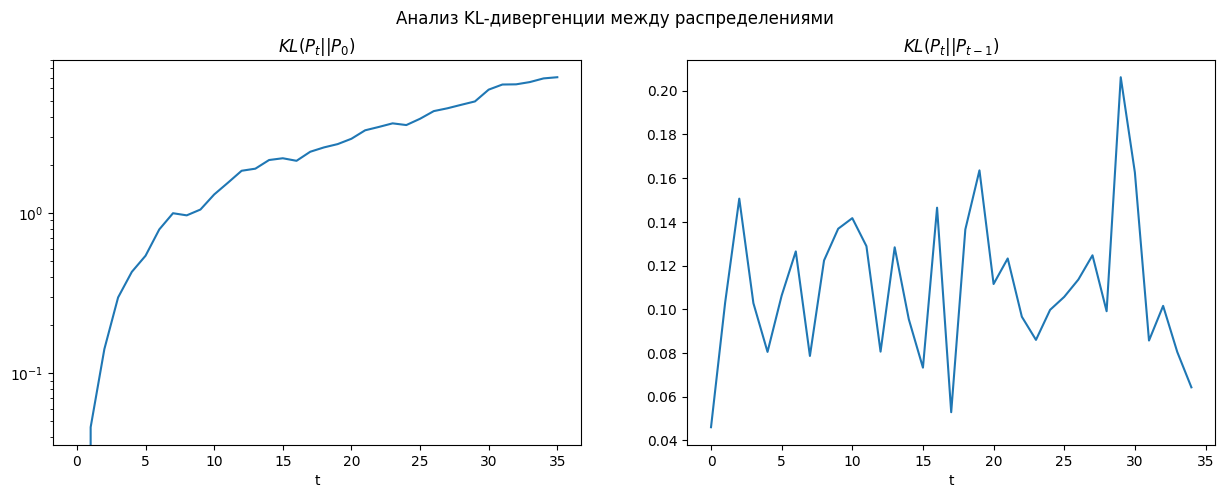

In [283]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
plt.plot(kl_users)
#plt.yscale('log')
plt.title(r'$KL(P_{t} || P_{0})$')
plt.xlabel('t')


plt.subplot(1, 2, 2)
plt.plot(kl_between_users)
plt.title(r'$KL(P_{t} || P_{t-1})$')
plt.xlabel('t')

plt.suptitle('Анализ KL-дивергенции между распределениями')
plt.show()

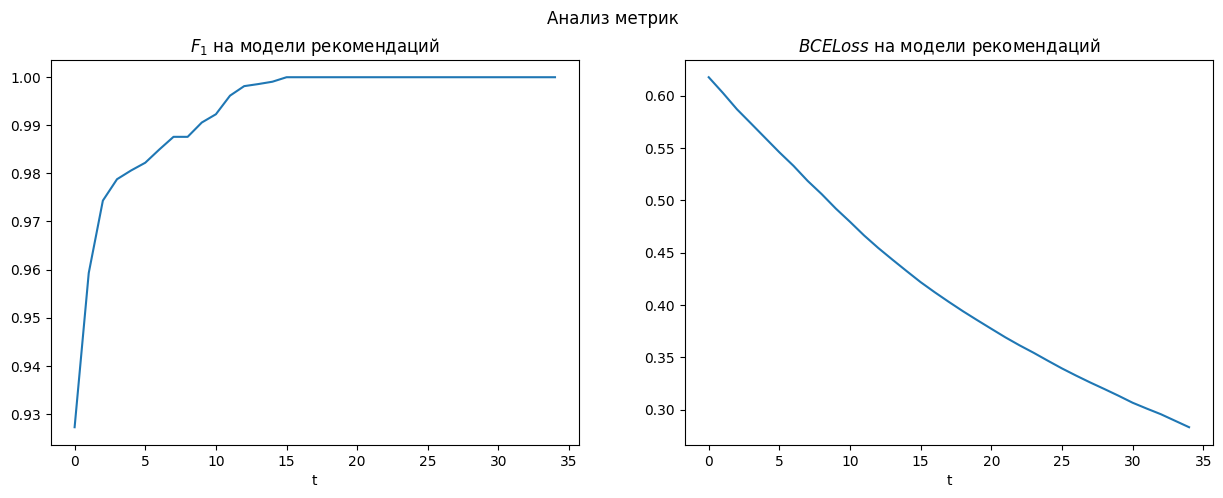

In [274]:
f1_rec_list = [history['history_rec']['train_f1'] for history in history_list]
loss_rec_list = [history['history_rec']['train_loss'] for history in history_list]

plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
plt.plot(f1_rec_list)
plt.title(r'$F_1 $ на модели рекомендаций')
plt.xlabel('t')


plt.subplot(1, 2, 2)
plt.plot(loss_rec_list)
plt.title(r'$BCELoss$ на модели рекомендаций')
plt.xlabel('t')

plt.suptitle('Анализ метрик')
plt.show()

In [270]:
arr = np.array([
                [1, 1],
                [1, 2],
                [2, 2],
                [2, 10],
                [11, 31],
                [1, -1]
])

np.cov(arr)

array([[  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0.5,   0. ,   4. ,  10. ,  -1. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   4. ,   0. ,  32. ,  80. ,  -8. ],
       [  0. ,  10. ,   0. ,  80. , 200. , -20. ],
       [  0. ,  -1. ,   0. ,  -8. , -20. ,   2. ]])

In [267]:
item_list = [items_embeddings.copy(), ]
item_loss_list = []
for tau in range(t):
  item_emb = np.load(f'item_emb_{tau}.npy')
  item_list.append(item_emb)
  loss_file = f'item_losses_arr_{tau}.npy'
  item_loss_list.append(np.load(loss_file))

print([x.shape for x in item_list])

[(3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20), (3221, 20)]


In [268]:
emb_list = [users_embeddings.copy(), ]
user_loss_list = []

for tau in range(t):
  user_emb = np.load(f'user_emb_{tau}.npy')
  emb_list.append(user_emb)
  loss_file = f'user_losses_arr_{tau}.npy'
  user_loss_list.append(np.load(loss_file))

print([x.shape for x in emb_list])

[(66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10), (66, 10)]


In [269]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
all_embeddings = np.concatenate(emb_list, axis=0)

pca = PCA(n_components=2)
pca.fit(all_embeddings)


all_projections = pca.transform(all_embeddings)
x_min, x_max = all_projections[:, 0].min(), all_projections[:, 0].max()
y_min, y_max = all_projections[:, 1].min(), all_projections[:, 1].max()

# 4. Создаем анимацию
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter([], [], alpha=0.6, cmap='viridis') # Добавляем cmap по умолчанию
cbar = fig.colorbar(scatter) # Создаем colorbar
cbar.set_label('Loss') # Подписываем colorbar


def init():
    ax.set_xlim(x_min - 0.1*(x_max-x_min), x_max + 0.1*(x_max-x_min))
    ax.set_ylim(y_min - 0.1*(y_max-y_min), y_max + 0.1*(y_max-y_min))
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('Эволюция эмбеддингов с Loss')
    ax.grid(True)
    return scatter, cbar

def update(frame):

    projected = pca.transform(emb_list[frame])
    user_losses = user_loss_list[frame]

    if projected.shape[0] == user_losses.shape[0]:
        scatter.set_offsets(projected)
        scatter.set_array(user_losses)
        scatter.set_clim(vmin=np.min(np.concatenate(user_loss_list)), vmax=np.max(np.concatenate(user_loss_list))) # Фиксируем пределы colorbar
        ax.set_title(f'Шаг {frame+1}/{len(user_loss_list)}')
        return scatter, cbar
    else:
        print(f"Предупреждение: Размеры эмбеддингов и лоссов не совпадают на шаге {frame+1}")
    return scatter, cbar

# Создаем анимацию
ani = FuncAnimation(fig, update, frames=len(user_loss_list),
                    init_func=init, blit=False, interval=1000) # blit=False, так как обновляем цвета

plt.close()
HTML(ani.to_html5_video())

<ipython-input-269-a10278cbfdc4>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter([], [], alpha=0.6, cmap='viridis') # Добавляем cmap по умолчанию


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 1. Собираем все эмбеддинги из history_list для единого PCA

all_embeddings = np.concatenate(emb_list, axis=0)

# 2. Создаем PCA на всех данных (фиксируем оси)
pca = PCA(n_components=2)
pca.fit(all_embeddings)  # Фитируем на всех данных сразу

# 3. Определяем границы осей (фиксируем масштаб)
all_projections = pca.transform(all_embeddings)
x_min, x_max = all_projections[:, 0].min(), all_projections[:, 0].max()
y_min, y_max = all_projections[:, 1].min(), all_projections[:, 1].max()

# 4. Создаем анимацию
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter([], [], alpha=0.6)

def init():
    ax.set_xlim(x_min - 0.1*(x_max-x_min), x_max + 0.1*(x_max-x_min))
    ax.set_ylim(y_min - 0.1*(y_max-y_min), y_max + 0.1*(y_max-y_min))
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('Эволюция эмбеддингов')
    ax.grid(True)
    return scatter,

def update(frame):
    # Проецируем эмбеддинги текущего шага
    projected = pca.transform(emb_list[frame])
    scatter.set_offsets(projected)
    ax.set_title(f'Шаг {frame+1}/{len(emb_list)}')
    return scatter,

# Создаем анимацию
ani = FuncAnimation(fig, update, frames=len(emb_list),
                    init_func=init, blit=True, interval=300)

plt.close()
HTML(ani.to_html5_video())

In [ ]:

# 1. Собираем все эмбеддинги из history_list для единого PCA

all_embeddings = np.concatenate(item_list, axis=0)

# 2. Создаем PCA на всех данных (фиксируем оси)
pca = PCA(n_components=2)
pca.fit(all_embeddings)  # Фитируем на всех данных сразу

# 3. Определяем границы осей (фиксируем масштаб)
all_projections = pca.transform(all_embeddings)
x_min, x_max = all_projections[:, 0].min(), all_projections[:, 0].max()
y_min, y_max = all_projections[:, 1].min(), all_projections[:, 1].max()
#x_min, x_max = -4, 4
#y_min, y_max = -4, 4
# 4. Создаем анимацию
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter([], [], alpha=0.6)

def init():
    ax.set_xlim(x_min - 0.1*(x_max-x_min), x_max + 0.1*(x_max-x_min))
    ax.set_ylim(y_min - 0.1*(y_max-y_min), y_max + 0.1*(y_max-y_min))
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('Эволюция эмбеддингов')
    ax.grid(True)
    return scatter,

def update(frame):
    # Проецируем эмбеддинги текущего шага
    projected = pca.transform(item_list[frame])
    scatter.set_offsets(projected)
    ax.set_title(f'Шаг {frame+1}/{len(item_list)}')
    return scatter,

# Создаем анимацию
ani = FuncAnimation(fig, update, frames=len(item_list),
                    init_func=init, blit=True, interval=300)

plt.close()
HTML(ani.to_html5_video())

In [ ]:
print(np.mean(userGAN.distrib_params['cov']))

0.0005897812210637971


In [ ]:
user_emb = dataset.users_embeddings

tsne = TSNE(n_components=2, perplexity=28, random_state=42)
embeddings_2d = tsne.fit_transform(user_emb)
mean_hat = np.mean(user_emb, axis=0)
cov_hat = np.cov(user_emb, rowvar=False)

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            alpha=0.6, label='Коорд. пользователей')

plt.title("t-SNE визуализация эмбеддингов пользователей")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
history_list

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Загрузка эмбеддингов пользователей
user_emb = dataset.users_embeddings

# Применение PCA для уменьшения размерности до 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(user_emb)

# Вычисление статистик (для справки)
mean_hat = np.mean(user_emb, axis=0)
cov_hat = np.cov(user_emb, rowvar=False)

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            alpha=0.6, label='Пользовательские эмбеддинги')

# Добавим информацию о дисперсии
plt.title(f"PCA визуализация эмбеддингов пользователей\nОбъясненная дисперсия: {pca.explained_variance_ratio_.sum():.2f}")
plt.xlabel(f"Главная компонента 1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"Главная компонента 2 ({pca.explained_variance_ratio_[1]:.2%})")

plt.legend()
plt.grid(True)
plt.show()

#### отладка кода

In [ ]:
rec_dataset = RecommendationDataset(dataset,
                                    user_embedding_dim=user_embedding_dim_rec,
                                    item_embedding_dim=item_embedding_dim_rec)
choice_dataset = UserBehaviorDataset(dataset,
                                      K=K,
                                      user_embedding_dim=user_embedding_dim_choice,
                                      item_embedding_dim=item_embedding_dim_choice)
print('Датасеты создались')

In [ ]:
#также из обновленного датасета дообучаем алгоритм выбора пользователей
a_rec, history_rec = train_model(a_rec, rec_dataset, num_epoch=1)
a_choice, history_choice = train_model(a_choice, choice_dataset, num_epoch=1)
print('Модели обучились')

In [ ]:
user_transformer = PCA(n_components=user_embedding_dim_rec)
item_transformer = PCA(n_components=item_embedding_dim_rec)
users_embeddings = user_transformer.fit_transform(dataset.users_embeddings.copy())
items_embeddings = item_transformer.fit_transform(dataset.items_embeddings.copy())
recommendations = dict()
user_ids = list(range(len(users_embeddings)))
for user_id in user_ids:
  a_rec.eval()
  user_emb = torch.FloatTensor(users_embeddings[user_id]).to(device)
  items_emb = torch.FloatTensor(items_embeddings).to(device)
  user_emb = (user_emb.expand(items_emb.shape[0], -1)).detach().clone().to(device)
  with torch.no_grad():
    scores = a_rec(user_emb, items_emb)
    top_k_indices = torch.topk(scores, k=K, dim=0).indices.squeeze().cpu().numpy()
  recommendations[user_id] = top_k_indices
print('Рекомендации подобраны')


#моделируем взаимодействие пользователя с topK рекомендациями, предложенными ему
interactions = []
for user_id, item_indices in recommendations.items():
  user_emb = torch.FloatTensor(dataset.users_embeddings[user_id]).to(device).unsqueeze(0)
  items_emb = torch.FloatTensor(dataset.items_embeddings[item_indices]).to(device).unsqueeze(0)
  with torch.no_grad():
      predictions = a_choice(user_emb, items_emb)
      choices = (predictions > 0.6).float().squeeze(0).detach().cpu()

  for item_idx, choice in zip(item_indices, choices):
      if choice == 1:
          interactions.append((user_id, item_idx))

print('Пользователи отреагировали на рекомендации')


In [ ]:
interactions